""

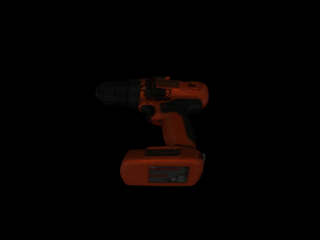

In [44]:
import os
os.environ['MUJOCO_GL'] = 'egl' 

import mujoco
import mujoco.viewer
import mediapy as media

base_file_path = '../asset/ycb_merged_v2/xml'
file_name = 'power_drill.xml'
object_xml_path = os.path.join(base_file_path, file_name)
model = mujoco.MjModel.from_xml_path(object_xml_path)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    
    media.show_image(renderer.render())


""

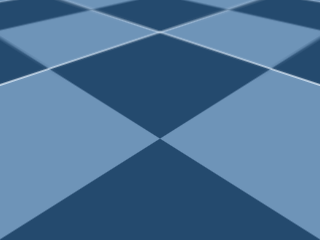

In [45]:
env_xml_path = '../asset/scene_ycb.xml'
model = mujoco.MjModel.from_xml_path(env_xml_path)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="fixed")
    
    media.show_image(renderer.render())

Successfully merged XMLs into: ../asset/merged.xml


""

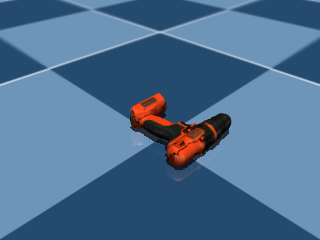

In [50]:
import xml.etree.ElementTree as ET
from xml.dom import minidom
import cv2

def print_tree(element, level=0):
    """Pretty printing with line structure"""
    indent = "│   " * (level-1) + "├── " if level > 0 else ""
    # Print current element
    print(f"{indent}{element.tag}")
    
    # Print children
    for i, child in enumerate(element):
        is_last = i == len(list(element)) - 1
        if is_last and level > 0:
            print_tree(child, level + 1)
        else:
            print_tree(child, level + 1)

def merge_mujoco_xmls(env_path, object_path, output_path):
    """
    Merge two MuJoCo XML files while preserving asset references.
    
    Args:
        env_path (str): Path to the environment XML file
        object_path (str): Path to the object XML file
        output_path (str): Path where the merged XML will be saved
    """
    # Parse both XML files
    env_tree = ET.parse(env_path)
    obj_tree = ET.parse(object_path)
    
    env_root = env_tree.getroot()
    obj_root = obj_tree.getroot()
    
    # Get the base directories for both XMLs
    env_dir = os.path.dirname(env_path)
    obj_dir = os.path.dirname(object_path)
    output_dir = os.path.dirname(output_path)
    
    # Function to update asset paths
    def update_asset_paths(element, base_dir, new_dir):
        # List of attributes that might contain file paths
        path_attributes = ['file']
        
        for attr in path_attributes:
            if attr in element.attrib:
                old_path = element.attrib[attr]
                if not os.path.isabs(old_path):
                    # Convert to absolute path relative to original XML
                    abs_path = os.path.normpath(os.path.join(base_dir, old_path))
                    # Convert to relative path from new XML location
                    new_path = os.path.relpath(abs_path, new_dir)
                    element.attrib[attr] = new_path
        
        # Recursively process children
        for child in element:
            update_asset_paths(child, base_dir, new_dir)
    
    # Update asset paths in both trees
    update_asset_paths(env_root, env_dir, output_dir)
    update_asset_paths(obj_root, obj_dir, output_dir)
    
    # Find worldbody elements
    env_worldbody = env_root.find('.//worldbody')
    obj_worldbody = obj_root.find('.//worldbody')
    
    if env_worldbody is None or obj_worldbody is None:
        raise ValueError("Both XML files must contain a worldbody element")
    
    # Merge assets section if present
    env_asset = env_root.find('asset')
    obj_asset = obj_root.find('asset')
    
    if obj_asset is not None:
        if env_asset is None:
            env_asset = ET.SubElement(env_root, 'asset')
        for asset in obj_asset:
            env_asset.append(asset)
    
    # Move all children from object's worldbody to environment's worldbody
    for child in obj_worldbody:
        env_worldbody.append(child)
    
    # Save the merged XML
    rough_string = ET.tostring(env_root, encoding='utf-8')
    reparsed = minidom.parseString(rough_string)
    
    # Format the XML
    formatted_xml = reparsed.toprettyxml(indent="  ")
    
    # Remove empty lines
    formatted_xml = '\n'.join([line for line in formatted_xml.split('\n') if line.strip()])
    
    # Write to file
    with open(output_path, 'w') as f:
        f.write(formatted_xml)
    # env_tree.write(output_path, encoding='utf-8', xml_declaration=True)


# Example paths - adjust these to your actual file locations
env_xml = env_xml_path
object_xml = object_xml_path
output_xml = "../asset/merged.xml"

try:
    merge_mujoco_xmls(env_xml, object_xml, output_xml)
    print(f"Successfully merged XMLs into: {output_xml}")
except Exception as e:
    print(f"Error merging XMLs: {str(e)}")
    
model = mujoco.MjModel.from_xml_path(output_xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="fixed")
    
    media.show_image(renderer.render())
    
    # save image
    cv2.imwrite('../mujoco_obj.png', cv2.cvtColor(renderer.render(), cv2.COLOR_RGB2BGR))